![LOGO_PUJ.png](https://epilab.co/wp-content/uploads/2019/02/Epigenetica-Y-Cancer-Javeriana-2.png)



# **Procesamiento de Alto Volumen de Datos**
---
**Autor**: Paula Andrea Velasquez Romero

**Fecha**: 19 de marzo 2025

------

###**Problematica**:
La calidad del agua es esencial para la vida y el bienestar humano, determinada por propiedades físicas, químicas y biológicas [1]. En la India, este recurso enfrenta una grave crisis por la contaminación. Millones de personas consumen agua no apta, afectando la salud pública. Ante este contexto, el aprendizaje automático ofrece herramientas eficaces para analizar datos y predecir la potabilidad del agua. Este estudio aplica modelos de ML para anticipar tendencias de contaminación y apoyar decisiones sostenibles.


###**Objetivo**:
Implementar modelos de predicción utilizando la biblioteca de aprendizaje automático MLlib en PySpark, con el fin de explorar y aplicar técnicas de inteligencia artificial en entornos de procesamiento con altos volumenes de datos.

###**Metodología**:

1. *Importación de datos:* Lectura del archivo CSV desde Google Drive.

2. *Preprocesamiento:* Limpieza de valores nulos, cambio de tipos de datos y análisis exploratorio de distribuciones y relaciones entre las características del agua.

3. *Entrenamiento del modelo:* Se entrenan modelos de regresión lineal (MLlib) y aprendizaje profundo (Keras) para predecir el WQI (índice de calidad del agua).

4. *Evaluación del modelo:* Cálculo de accuracy, precision, recall y F1-score para medir el rendimiento de los modelos.

____________________________________________________

In [117]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F #Permite creación de funciones
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

from pyspark.ml.evaluation import RegressionEvaluator

##**Cargar los datos desde Google Drive**

In [85]:
# Se conecta con el drive de google, para tener los datos cerca
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
#Cargar datos desde Google Drive
rutaCSV = "/content/drive/MyDrive/Predicción_Calidad_del_Agua/waterquality.csv"
rutaIndia = "/content/drive/MyDrive/Predicción_Calidad_del_Agua/Indian_States/Indian_States.shp"

In [87]:
#Importar OS de Google
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

In [88]:
df00 = spark.read.csv(rutaCSV, header=True, inferSchema=True)
gpdf00 = gpd.read_file(rutaIndia)

In [89]:
## Se hace inspeccion sobre los datos CSV
df00.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|8.0|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

## **Análisis y Preparación de Datos: Archivo CSV**
Se presentan los datos que contienen los parámetros de diferentes rios en la India. Cada dato o parámetro es el promedio de valores medidos sobre un período de tiempo. Los datos han sido extraidos de la web oficial de datos de la India.


- Tipo de Datos: Coherencia de tipo de datos, transformación.
- Columnas: Conocimiento de columnas, eliminación de necesarias
- Análisis de Datos Nulos o Imposibles: Conocimiento cantidad, acción.

#Tipos de Datos: conocimiento y análisis

In [90]:
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'TOTAL_COLIFORM']

Se presentan los parámetros y sus definiciones de la calidad del agua en las regiones de la India. La definición de las fuentes, impactos, efectos y métodos de medida de la base de datos: no son contempladas en el presente estudio. Las definiciones de los parámetros dados por la base de datos son extraidos de **[2]**.

- STATION CODE: Código de estación
- LOCATIONS: Ubicación de estación (Ubicación del Rio)
- STATE: Estado/Lugar de la India
- TEMP: Temperatura promedio del agua (°C)
- DO: Oxigeno Disuelto (mg/L). Concentraciones altas de oxigeno disuelto representa mejor calidad del agua.
- pH: Se define como el logaritmo negativo de la concentración de hidrógeno. Número adimensional que indica la acidez o base de una solución **[3]**.
- CONDUCTIVITY: Mide la habilidad de una solución conducir corriente electrica **[4]**. El agua pura no es buen conductor de electricidad **[5]**.
- BOD: Las bacterias y otros microorganismos utilizan sustancias orgánicas como alimento (Demanda Bioquímica de Oxigeno). A medida que metabolizan la materia orgánica, consumen oxígeno **[4]**. Mayor cantidad de material orgánico en el agua, mayor valor de BOD.
- 'NITRATE_N_NITRITE_N': Nitrito y Nitrato Nitrogeno. Altas concentraciones de N en la superficie del agua puede estimular el rápido crecimiento de algas las cuales degradan la calidad del agua (mg/L). **[4]**.
- 'FECAL_COLIFORM': Promedio de bacterias coliforms (excresiones) **[6]** .
-  'TOTAL_COLIFORM: Cantidad total de coliformes. Se retira del dataset ya que no aporta información promedio sobre los datos.

In [91]:
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

#Tipo de Datos
* Se observa que los datos se encuentran en tipo string. Se procede a cambiar a tipo de datos double.

In [92]:
df00 = df00.withColumn('TEMP', df00['TEMP'].cast(FloatType()))
df00 = df00.withColumn('pH', df00['pH'].cast(FloatType()))
df00 = df00.withColumn('DO', df00['DO'].cast(FloatType()))
df00 = df00.withColumn('CONDUCTIVITY', df00['CONDUCTIVITY'].cast(FloatType()))
df00 = df00.withColumn('NITRATE_N_NITRITE_N', df00['NITRATE_N_NITRITE_N'].cast(FloatType()))
df00 = df00.withColumn('FECAL_COLIFORM', df00['FECAL_COLIFORM'].cast(FloatType()))
df00 = df00.withColumn('BOD', df00['BOD'].cast(FloatType()))
df00 = df00.withColumn('TOTAL_COLIFORM', df00['TOTAL_COLIFORM'].cast(FloatType()))
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'float')]

In [93]:
# Se elimina TOTAL_COLIFORM, no aporta a la investigación
df00 = df00.drop('TOTAL_COLIFORM')
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM']

# Cantidad de Datos Núlos o Imposibles.

In [94]:
df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   5|  2|  0|          30|  6|                  2|            82|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



Se requiere limpiar los datos de los nulos o imposibles. Para ello se hará una tabla (ofrece mejor rendiminento para consultas SQL: Procesamiento de Alto Volumen de Datos) y posteriormente una consulta sql para eliminar los datos que No se requieren. A continuación los pasos:
* Se crea la tabla
* Se hace la consulta a la Tabla



In [95]:
df00.createOrReplaceTempView("df00_sql")

In [96]:
##Se hace la consulta, que retorna el df00 limpio, que se llamará df01
df01 = spark.sql('''Select * from df00_sql where TEMP is not null and
                    DO is not null and
                    pH is not null and
                    CONDUCTIVITY is not null and
                    BOD is not null and
                    NITRATE_N_NITRITE_N is not null and
                    FECAL_COLIFORM is not null''')

* Se verifica la eliminación de Datos Nulos o Imposibles

In [97]:
df01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



* Se presenta información estadística de las columnas

In [16]:
for col in df01.columns:
  df01.describe([col]).show()

+-------+------------------+
|summary|      STATION CODE|
+-------+------------------+
|  count|               447|
|   mean|2056.6196868008947|
| stddev| 750.6013394156962|
|    min|                11|
|    max|              3330|
+-------+------------------+

+-------+-------------------+
|summary|          LOCATIONS|
+-------+-------------------+
|  count|                447|
|   mean|               NULL|
| stddev|               NULL|
|    min|          AHMEDABAD|
|    max|ZUARI AT PANCHAWADI|
+-------+-------------------+

+-------+--------------+
|summary|         STATE|
+-------+--------------+
|  count|           447|
|   mean|          NULL|
| stddev|          NULL|
|    min|ANDHRA PRADESH|
|    max|   WEST BENGAL|
+-------+--------------+

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|              447|
|   mean|25.49843395369698|
| stddev| 3.31128283673611|
|    min|             10.5|
|    max|             33.8|
+-------+--------

#Visualización de los Datos
* Para cada parámetro de concentración promedio, se hará una consulta SQL desde la tabla temporal, y posteriormente se un RDD con una *función lambda* para colectar los datos (vector de datos).
* RDD (Resilient Distributed Dataset) es una estructura de datos de Apache Spark que permite procesar datos en paralelo. Los RDD son la principal abstracción de datos de Spark y se encuentran en el núcleo del sistema de computación.

In [17]:
#Creación de tabla con datos limpios para visualizar los datos.
df01.createOrReplaceTempView("df01_sql")

In [18]:
#Hacer los vectores de la tabla para cada parámetro.
DO_parametro= spark.sql("select DO from df01_sql")
DO_parametro= DO_parametro.rdd.map(lambda fila: fila.DO).collect()
pH_parametro= spark.sql("select pH from df01_sql")
pH_parametro= pH_parametro.rdd.map(lambda fila: fila.pH).collect()
COND_parametro= spark.sql("select CONDUCTIVITY from df01_sql")
COND_parametro= COND_parametro.rdd.map(lambda fila: fila.CONDUCTIVITY).collect()
BOD_parametro= spark.sql("select BOD from df01_sql")
BOD_parametro= BOD_parametro.rdd.map(lambda fila: fila.BOD).collect()
NN_parametro= spark.sql("select NITRATE_N_NITRITE_N from df01_sql")
NN_parametro= NN_parametro.rdd.map(lambda fila: fila.NITRATE_N_NITRITE_N).collect()
FC_parametro= spark.sql("select FECAL_COLIFORM from df01_sql")
FC_parametro= FC_parametro.rdd.map(lambda fila: fila.FECAL_COLIFORM).collect()

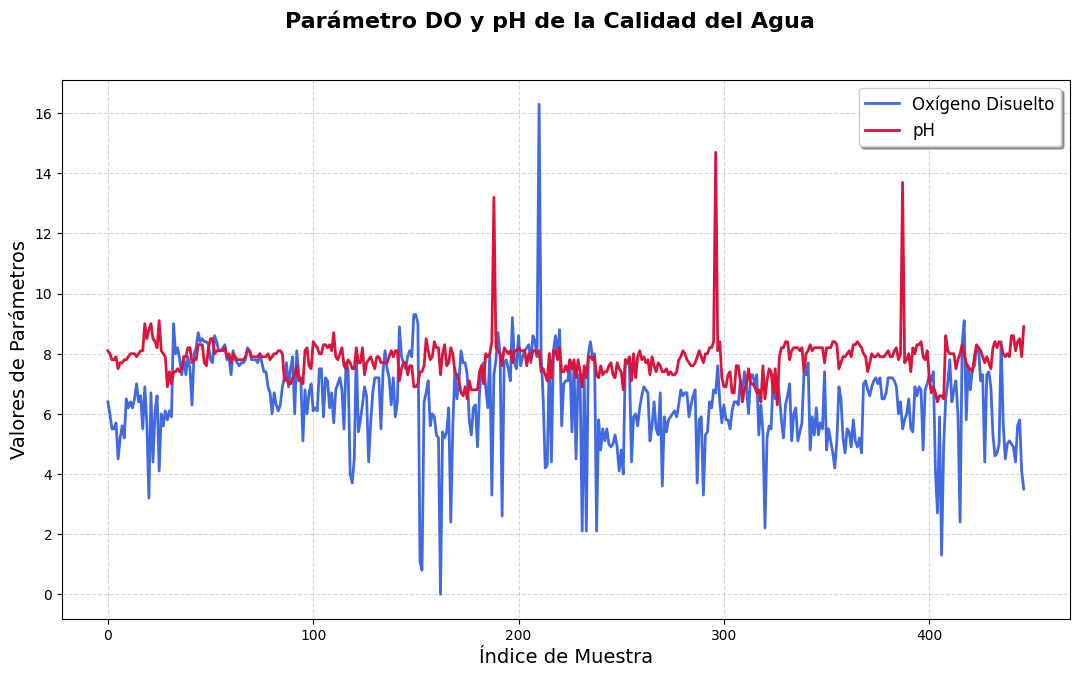

In [19]:
#Se grafica los parámetros DO y pH
tam = len(DO_parametro)
fig, ax1 = plt.subplots(figsize=(13, 7), facecolor='w', edgecolor='k')
ax1.plot(range(0, tam), DO_parametro, color='royalblue', linewidth=2, label='Oxígeno Disuelto')
ax1.plot(range(0, tam), pH_parametro, color='crimson', linewidth=2, label='pH')
fig.suptitle('Parámetro DO y pH de la Calidad del Agua', fontsize=16, fontweight='bold')
ax1.set_xlabel('Índice de Muestra', fontsize=14)
ax1.set_ylabel('Valores de Parámetros', fontsize=14)
legend = ax1.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)
ax1.grid(True, linestyle="--", alpha=0.5)
plt.show()


###Análisis:
La gráfica muestra la variación del oxígeno disuelto (DO) y el pH en muestras de calidad del agua. La línea azul representa el DO, con fluctuaciones pronunciadas y picos que indican posibles variaciones en la oxigenación del agua. En contraste, la línea roja del pH es más estable, pero presenta algunos picos que podrían indicar anomalías en la acidez o alcalinidad del agua. En general, se observa una mayor variabilidad en el DO en comparación con el pH, lo que sugiere que el oxígeno disuelto es más sensible a cambios en las condiciones del agua.

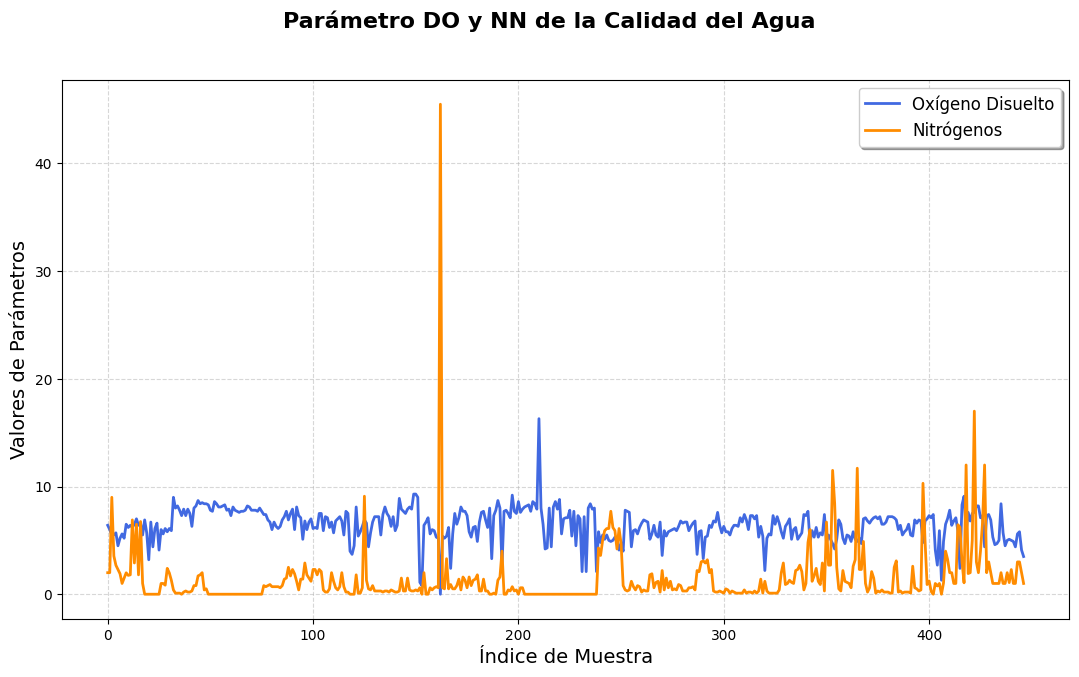

In [20]:
#Se grafica los parámetros DO y Nitrogenos
tam = len(DO_parametro)
fig, ax1 = plt.subplots(figsize=(13, 7), facecolor='w', edgecolor='k')
ax1.plot(range(0, tam), DO_parametro, color='royalblue', linewidth=2, label='Oxígeno Disuelto')
ax1.plot(range(0, tam), NN_parametro, color='darkorange', linewidth=2, label='Nitrógenos')
fig.suptitle('Parámetro DO y NN de la Calidad del Agua', fontsize=16, fontweight='bold')
ax1.set_xlabel('Índice de Muestra', fontsize=14)
ax1.set_ylabel('Valores de Parámetros', fontsize=14)
legend = ax1.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)
ax1.grid(True, linestyle="--", alpha=0.5)
plt.show()

###Analáisis:

La gráfica muestra la relación entre el oxígeno disuelto (DO) y los compuestos nitrogenados (NN) en la calidad del agua. El DO (línea azul) mantiene una tendencia relativamente estable con variaciones moderadas, mientras que los NN (línea naranja) presentan valores bajos en la mayor parte del tiempo, pero con picos esporádicos muy elevados. Estos picos en NN podrían indicar episodios de contaminación o descargas puntuales de nitrógeno, lo que afectaría la calidad del agua y posiblemente influiría en los niveles de oxígeno disuelto.









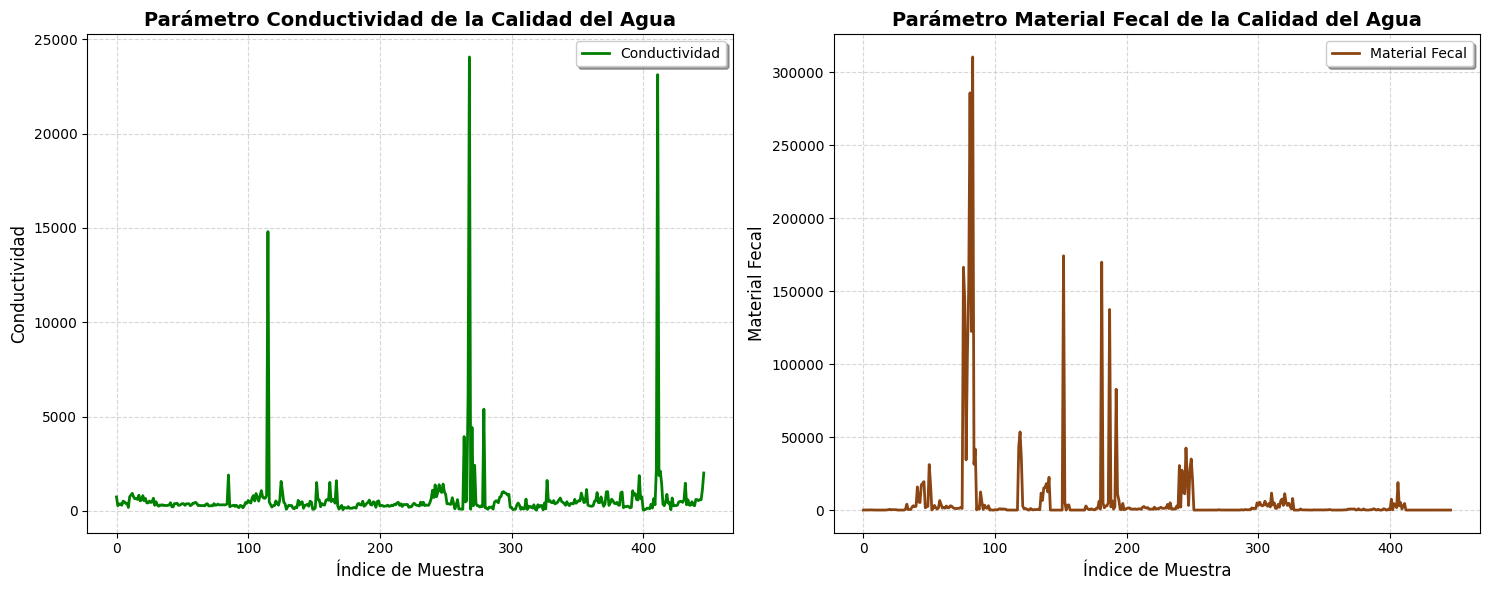

In [21]:
#Se grafica la conductividad y Material fecal

tam = len(COND_parametro)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), facecolor='w', edgecolor='k')
ax1.plot(range(0, tam), COND_parametro, color='green', linewidth=2, label='Conductividad')
ax1.set_title('Parámetro Conductividad de la Calidad del Agua', fontsize=14, fontweight='bold')
ax1.set_xlabel('Índice de Muestra', fontsize=12)
ax1.set_ylabel('Conductividad', fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
ax2.plot(range(0, tam), FC_parametro, color='saddlebrown', linewidth=2, label='Material Fecal')
ax2.set_title('Parámetro Material Fecal de la Calidad del Agua', fontsize=14, fontweight='bold')
ax2.set_xlabel('Índice de Muestra', fontsize=12)
ax2.set_ylabel('Material Fecal', fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.5)
ax2.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

###Análisis:

Las gráficas muestran la variabilidad de la conductividad y el material fecal en la calidad del agua a lo largo de diferentes muestras. Se observan picos extremos en ambas variables, lo que indica fluctuaciones significativas en la calidad del agua, posiblemente debido a descargas contaminantes o factores ambientales. La conductividad presenta valores generalmente bajos con algunos aumentos drásticos, mientras que el material fecal tiene un comportamiento similar con picos aún más pronunciados, sugiriendo eventos de contaminación puntual.

# **Ingeniería de Características**


**Water Quality Index:** El Índice de la Calidad del Agua se calcula agregando  linealmente el índice de calidad con el peso.

WQI = sum(**qr**n * **W**n)

**qr**n: Rango de Calidad para el n parámetro de calidad de agua.

**W**n: Unidad de peso para el n parámetro.

A continuación se calcula un método estándar **[2]** para calcular el rango de calidad **qr** para cada parámetro.

* Rango de calidad para **pH**. Se crea una nueva columna con los rangos **pH** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **pH = [7.0 ; 8.5]**
    + 80:  *agua moderada*     **pH = [6.8 ; 6.9) o (8.5 ; 8.6)**
    + 60:  *agua dura* **pH = [6.7 ; 6.8) o [8.6 ; 8.8)**
    + 40:  *agua muy dura* **pH = [6.5 ; 6.7) o [8.8 ; 9.0)**
    + 0:   rango agua residuales

In [22]:
#Función definida por el usuario para definir el rango de calidad de agua según el pH
#Se crea la columna para los rangos del pH del parámetro
df02 = df01.withColumn(
    'qrPH',
    F.when((df01.pH >= 7.0) & (df01.pH <8.5), 100)  # Agua dulce
     .when(((df01.pH >= 6.8) & (df01.pH < 6.9)) | ((df01.pH > 8.5) & (df01.pH < 8.6)), 80)  # Agua moderada
     .when(((df01.pH >= 6.7) & (df01.pH < 6.8)) | ((df01.pH >= 8.6) & (df01.pH < 8.8)), 60)  # Agua dura
     .when(((df01.pH >= 6.5) & (df01.pH < 6.7)) | ((df01.pH >= 8.8) & (df01.pH < 9.0)), 40)  # Agua muy dura
     .otherwise(0)  # Agua residual
)

* Rango de calidad para **Oxigeno Disuelto**. Se crea una nueva columna con los rangos DO de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **DO>=6.0**
    + 80:  *agua moderada* **DO = [5.1, 6.0)**
    + 60:  *agua dura* **DO = [4.1, 5.0]**
    + 40:  *agua muy dura* **DO = [3.0, 4.0]**
    + 0:   rango agua residuales

In [23]:
#Función definida por el usuario para definir el rango de calidad de agua según DO
#Se crea la columna para los rangos del parámetro
df02 = df02.withColumn(
    'qrDO',
    F.when((df01.DO >= 6.0), 100)  # Agua dulce
     .when(((df01.DO >= 5.1) & (df01.DO <6)), 80)  # Agua moderada
     .when(((df01.DO >= 4.1) & (df01.DO <= 5.0)), 60)  # Agua dura
     .when(((df01.DO >= 3.0) & (df01.DO <= 4.0)), 40)  # Agua muy dura
     .otherwise(0)  # Agua residual
)

* Rango de calidad para **Conductividad**. Se crea una nueva columna con los rangos CONDUCTIVITY de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **CONDUCTIVITY = [0.0,75.0]**
    + 80:  *agua moderada* **CONDUCTIVITY = (75.0, 150.0]**
    + 60:  *agua dura* **CONDUCTIVITY = (150.0, 225.0]**
    + 40:  *agua muy dura* **CONDUCTIVITY = (225.0, 300.0]**
    + 0:   rango agua residuales

In [24]:
#Función definida por el usuario para definir el rango de calidad de agua según CONDUCTIVITY
#Se crea la columna para los rangos del parámetro
df02 = df02.withColumn(
    'qrCOND',
    F.when(((df01.CONDUCTIVITY >= 0.0) & (df01.CONDUCTIVITY <= 75.0)), 100)  # Agua dulce
     .when(((df01.CONDUCTIVITY > 75.0) & (df01.CONDUCTIVITY <=150.0)), 80)  # Agua moderada
     .when(((df01.CONDUCTIVITY > 150.0) & (df01.CONDUCTIVITY <=225.0)), 60)  # Agua dura
     .when(((df01.CONDUCTIVITY > 225.0) & (df01.CONDUCTIVITY <= 300.0)), 40)  # Agua muy dura
     .otherwise(0)  # Agua residual
)

* Rango de calidad para **Demanda Bioquímica de Oxigeno**. Se crea una nueva columna con los rangos **BOD** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **BOD = [0.0,3.0)**
    + 80:  *agua moderada* **BOD = [3.0, 6.0)**
    + 60:  *agua dura* **BOD = [6.0, 80.0)**
    + 40:  *agua muy dura* **BOD = [80.0, 125.0)**
    + 0:   rango agua residuales

In [25]:
#Función definida por el usuario para definir el rango de calidad de agua según CONDUCTIVITY
#Se crea la columna para los rangos del parámetro
df02 = df02.withColumn(
    'qrBOD',
    F.when(((df01.BOD >= 0.0) & (df01.BOD < 3.0)), 100)  # Agua dulce
     .when(((df01.BOD >= 3.0) & (df01.BOD < 6.0)), 80)  # Agua moderada
     .when(((df01.BOD >= 6.0) & (df01.BOD < 80.0)), 60)  # Agua dura
     .when(((df01.BOD >= 80.0) & (df01.BOD < 125.0)), 40)  # Agua muy dura
     .otherwise(0)  # Agua residual
)

* Rango de calidad para **Nitratos**. Se crea una nueva columna con los rangos **NITRATE_N_NITRITE_N** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **NITRATE_N_NITRITE_N = [0.0,20.0)**
    + 80:  *agua moderada* **NITRATE_N_NITRITE_N =  [20.0, 50.)**
    + 60:  *agua dura* **NITRATE_N_NITRITE_N = [50.0, 100.0)**
    + 40:  *agua muy dura* **NITRATE_N_NITRITE_N = [100.0, 200.0]**
    + 0:   rango agua residuales

In [26]:
#Función definida por el usuario para definir el rango de calidad de agua según NITRATE_N_NITRITE_N
#Se crea la columna para los rangos del parámetro
df02 = df02.withColumn(
    'qrNN',
    F.when(((df01.NITRATE_N_NITRITE_N  >= 0.0) & (df01.NITRATE_N_NITRITE_N  < 20.0)), 100)  # Agua dulce
     .when(((df01.NITRATE_N_NITRITE_N  >= 20.0) & (df01.NITRATE_N_NITRITE_N  < 50.0)), 80)  # Agua moderada
     .when(((df01.NITRATE_N_NITRITE_N  >= 50.0) & (df01.NITRATE_N_NITRITE_N  < 100.0)), 60)  # Agua dura
     .when(((df01.NITRATE_N_NITRITE_N  >= 100.0) & (df01.NITRATE_N_NITRITE_N <= 200.0)), 40)  # Agua muy dura
     .otherwise(0)  # Agua residual
)

* Rango de calidad para **Coliforme Fecal**. Se crea una nueva columna con los rangos FECAL_COLIFORM de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **FECAL_COLIFORM = [0.0,5.0)**
    + 80:  *agua moderada* **FECAL_COLIFORM = [5.0, 50.0)**
    + 60:  *agua dura* **FECAL_COLIFORM = [50.0, 500.0)**
    + 40:  *agua muy dura* **FECAL_COLIFORM = [500.0, 10000.0)**
    + 0:   rango agua residuales

In [27]:
#Función definida por el usuario para definir el rango de calidad de agua según FECAL_COLIFORM
#Se crea la columna para los rangos del parámetro
df02 = df02.withColumn(
    'qrFC',
    F.when(((df01.FECAL_COLIFORM  >= 0.0) & (df01.FECAL_COLIFORM  < 5.0)), 100)  # Agua dulce
     .when(((df01.FECAL_COLIFORM  >= 5.0) & (df01.FECAL_COLIFORM  < 50.0)), 80)  # Agua moderada
     .when(((df01.FECAL_COLIFORM  >= 50.0) & (df01.FECAL_COLIFORM  < 500.0)), 60)  # Agua dura
     .when(((df01.FECAL_COLIFORM  >= 500.0) & (df01.FECAL_COLIFORM < 10000.0)), 40)  # Agua muy dura
     .otherwise(0)  # Agua residual
)

In [28]:
#Inspección visual del datframe spark
df02.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|  60|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0| 100|  80|     0|   80| 100|  60|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.6|               3.55|          90.0| 100|

In [29]:
df02.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrPH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNN',
 'qrFC']

A continuación se cálcula el WQI para cada parámetro.

La masa del agua puede ser calculado por el producto de su volumen por su densidad. La densidad del agua es aproximadamente 1 gramo por centimetro cúbico (g/cm^3)

In [30]:
df03=df02.withColumn('wpH', df02.qrPH*0.165)
df03=df03.withColumn('wDO', df02.qrDO*0.281)
df03=df03.withColumn('wCOND', df02.qrCOND*0.234)
df03=df03.withColumn('wBOD', df02.qrBOD*0.009)
df03=df03.withColumn('wNN', df02.qrNN*0.028)
df03=df03.withColumn('wFC', df02.qrFC*0.281)

In [31]:
df03.select([F.round(c, 2).alias(c) if dict(df03.dtypes)[c] in ('double', 'float') else F.col(c) for c in df03.columns]).show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC| wpH|  wDO|wCOND|wBOD|wNN|  wFC|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0|3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|16.5| 28.1|  0.0|0.72|2.8| 28.1|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0|3.1|                2.0|          72.0| 100| 100|    40|   80| 100|  60|16.5| 28.1| 9.36|0.72|2.8|16.86|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0|4.2|                9.0|          59.

Finalmente se calcula el **Índice de Calidad del Agua**

In [32]:
#Se crea la columna WQI <Nota>: recordar que son muy pocos los parámetros
df04=df03.withColumn('WQI', df03.wpH+df03.wBOD+df03.wCOND+df03.wFC+df03.wNN+df03.wDO)

In [33]:
#Se visualizan los datos
df04.select([F.round(c, 2).alias(c) if dict(df04.dtypes)[c] in ('double', 'float') else F.col(c) for c in df04.columns]).show(8)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+-----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC| wpH|  wDO|wCOND|wBOD|wNN|  wFC|  WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+-----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|16.5| 28.1|  0.0|0.72|2.8| 28.1|76.22|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|  60|16.5| 28.1| 9.36|0.72|2.8|16.86|74.34|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4

* A continuación se clasifica el agua sobre la base de su índice de calidad **[2]**

* Clasificación de calidad del agua:

    + Excelente: *agua dulce* **WQI = [0.0,25.0]**
    + Buena:  *agua moderada* **WQI = (25.0, 50.0]**
    + Baja:  *agua dura* **WQI = (50.0, 75.0]**
    + Muy_Baja:  *agua muy dura* **WQI = (75.0, 100.0]**
    + Inadecuada:   rango agua residuales

In [34]:
df05 = df04.withColumn(
    "CALIDAD",
    F.when((df04.WQI >= 0.0) & (df04.WQI <= 25.0), "Excelente")
    .when((df04.WQI > 25.0) & (df04.WQI <= 50.0), "Buena")
    .when((df04.WQI >50.0) & (df04.WQI <= 75.0), "Baja")
    .when((df04.WQI >75.0) & (df04.WQI <= 100.0), "Muy Baja")
    .otherwise("Inadecuada")
)

In [35]:
#Se visualizan los datos
df05.select([F.round(c, 2).alias(c) if dict(df05.dtypes)[c] in ('double', 'float') else F.col(c) for c in df05.columns]).show(16)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+-----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNN|qrFC| wpH|  wDO|wCOND|wBOD|wNN|  wFC|  WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+----+----+----+-----+-----+----+---+-----+-----+--------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80| 100| 100|16.5| 28.1|  0.0|0.72|2.8| 28.1|76.22|Muy Baja|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80| 100|  60|16.5| 28.1| 9.36|0.72|2.8|16.86|74.34|    Baja|
|        2182|GODAVARI RIVER A

#**Visualización de los datos por Estados de la INDIA**

* Se visualizan los datos obtenidos de CALIDAD en cada región/estado de la INDIA

In [36]:
#Primero se obtienen los nombres de regiones sobre el Dataframe de Calidad
df05.select('STATE').distinct().collect()

[Row(STATE='WEST BENGAL'),
 Row(STATE='GOA'),
 Row(STATE='RAJASTHAN'),
 Row(STATE='HIMACHAL PRADESH'),
 Row(STATE='GUJARAT'),
 Row(STATE='BIHAR'),
 Row(STATE='KARNATAKA'),
 Row(STATE='UTTAR PRADESH'),
 Row(STATE='MADHYA PRADESH'),
 Row(STATE='MAHARASHTRA'),
 Row(STATE='PUNJAB'),
 Row(STATE='TAMILNADU'),
 Row(STATE='ANDHRA PRADESH'),
 Row(STATE='KERALA'),
 Row(STATE='ASSAM')]

In [37]:
#Se visualiza los tipos de datos del dataframe  geográfico gpd
type(gpdf00)

geopandas.geodataframe.GeoDataFrame

* Se observan los nombres en el GPD, para hacer que sean similares frente a los del dataframe

In [38]:
gpdf00.columns

Index(['st_nm', 'geometry'], dtype='object')

In [39]:
#Nombres de los estados en GeoPandas
gpdf00['st_nm'].unique()

array(['Andaman & Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara & Nagar Havelli',
       'Daman & Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

In [40]:
#Se ajustan los nombres de GPD, eliminando caracteres y extensiones de nombres
gpdf01 = gpdf00.replace({'Andaman & Nicobar Island': 'Andaman and Nicobar Island',
                                   'Dadara & Nagar Havelli': 'Dadara and Nagar Havelli',
                                   'Daman & Diu': 'Daman an Diu',
                                   'Jammu & Kashmir': 'Jammu and Kashmir',
                                   'NCT of Delhi': 'Delhi'})
gpdf01['st_nm'].unique()

array(['Andaman and Nicobar Island', 'Arunanchal Pradesh', 'Assam',
       'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadara and Nagar Havelli',
       'Daman an Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

Se hacen cambios sobre el dataframe spark para coincidir nombres

* Para efectos de pintar el mapa se pasa el spark dataframe a pandas
* El nombre de TAMILNADU se cambia por TAMIL NADU
* Se deja sólo la letra inicial mayúsula sobre Dataframe

In [41]:
#Se cambia a objeto pandas
pandasDF = df05.toPandas()

#Cambio TAMILNADU a TAMIL NADU
pandasDF['STATE'].replace({'TAMILNADU': 'TAMIL NADU'}, inplace= True)

#Se deja letra inicial mayúscula en columna 'STATE'
pandasDF['STATE']= pandasDF['STATE'].str.title()

#Se comprueba el cambio
pandasDF['STATE'].head()

,STATE
0,Maharashtra
1,Maharashtra
2,Maharashtra
3,Maharashtra
4,Maharashtra


In [42]:
#Se cambia el nombre en el gpd a STATES
gpdf02 = gpdf01.rename(columns={'st_nm': 'STATE'})

#Se combinan los  dataframes (gpdf02, pandasDF) outer: union de claves 'STATE' de ambos dataframes
dfMap = pd.merge(gpdf02, pandasDF, on='STATE', how='outer')

#Se toman puntos a bajo coste que garantizan estar dentro de la geometria (mapa)
#Columna nueva coords
dfMap['coords'] =dfMap['geometry'].apply(lambda x: x.representative_point().coords[:])
dfMap['coords'] = [coords[0] for coords in dfMap['coords']]

#Se eliminan los datos duplicados
dfMap = dfMap.drop_duplicates(subset='STATE')

dfMap.head(10)

,STATE,geometry,STATION CODE,LOCATIONS,TEMP,DO,pH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,...,qrFC,wpH,wDO,wCOND,wBOD,wNN,wFC,WQI,CALIDAD,coords
0,Andaman and Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(92.83153129257889, 12.611584970470062)"
1,Andhra Pradesh,"MULTIPOLYGON (((81.1038 17.82269, 81.1061 17.8...",2360.0,"GODAVARI AT BASARA, ADILABAD",28.000000,5.5,8.1,826.0,1.7,1.0,...,80.0,16.5,22.48,0.00,0.9,2.8,22.48,65.16,Baja,"(79.61537165157097, 15.893833407885495)"
35,Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.1686 29.37432,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(95.03199805598612, 28.055114856615404)"
36,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.7429 26....",1260.0,BRAHAMPUTRA AT KHERGHAT (AFTER CONFL. WITH DIB...,22.299999,7.2,7.1,216.0,1.5,1.4,...,60.0,16.5,28.10,14.04,0.9,2.8,16.86,79.20,Muy Baja,"(90.76265036100918, 26.052225148671738)"
58,Bihar,"MULTIPOLYGON (((84.5072 24.26323, 84.50355 24....",1074.0,"GANGA AT BUXAR,BIHAR",24.500000,8.4,8.1,371.0,2.5,0.0,...,40.0,16.5,28.10,0.00,0.9,2.8,11.24,59.54,Baja,"(86.12533485112044, 25.902658098342613)"
118,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(76.78051175496091, 30.730184003289168)"
119,Chhattisgarh,"POLYGON ((83.33532 24.09885, 83.35346 24.09627...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(81.50899708552288, 20.94914121899211)"
120,Dadara and Nagar Havelli,"POLYGON ((73.20657 20.12216, 73.20797 20.1065,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(73.00811326266309, 20.206507820529538)"
121,Daman an Diu,"MULTIPOLYGON (((72.89335 20.44539, 72.89281 20...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(70.93083380880213, 20.71944808935791)"
122,Delhi,"POLYGON ((77.09361 28.8694, 77.10973 28.86722,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(77.12909320274471, 28.640197681028212)"


In [43]:
#Se instala mapClassify
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.6 MB/s eta 0:00:00


* Se procede a pintar con SEABORN

<Axes: >

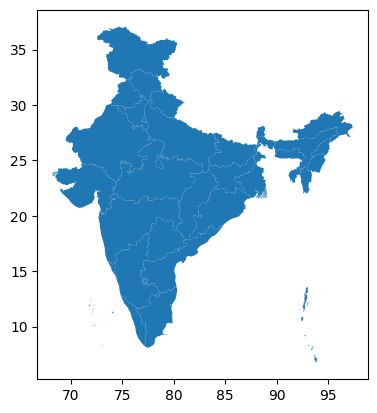

In [44]:
dfMap.plot(missing_kwds={'color': 'lightgrey'})

In [45]:
#Se instala adjustText para evitar que las etiquetas se sobrepongan en el mapa
!pip install adjustText

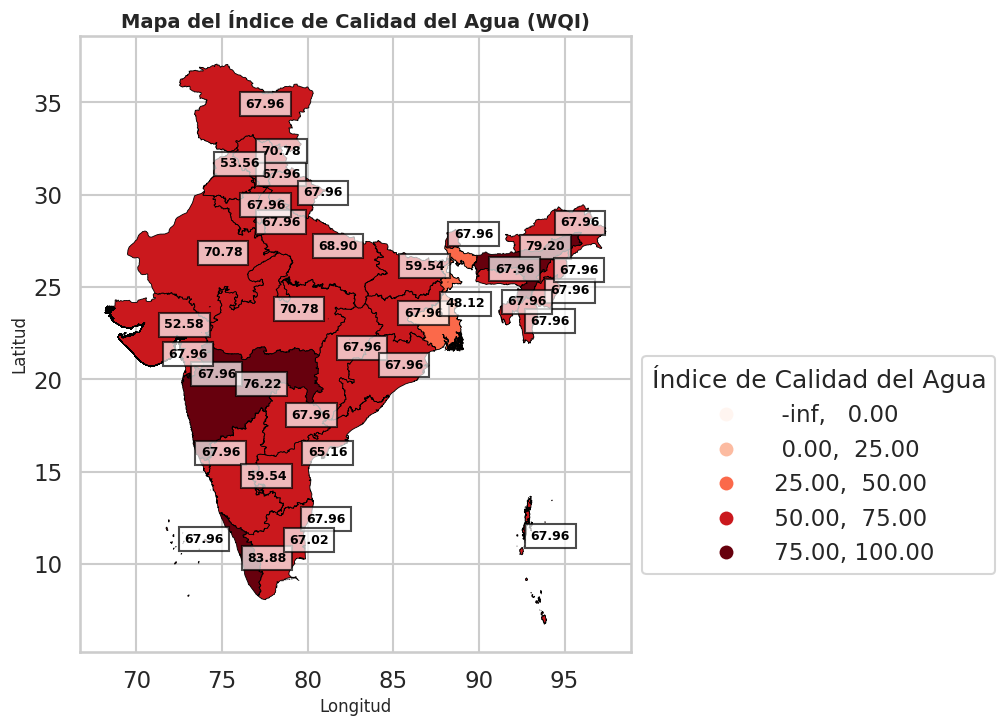

In [46]:
from adjustText import adjust_text  # Para evitar superposición de etiquetas

# Verificar y rellenar valores NaN en WQI con el promedio
dfMap['WQI'] = dfMap['WQI'].fillna(dfMap['WQI'].median())

# Configuración de estilo
sns.set_context("talk")
sns.set_style("whitegrid")

# Crear la figura
fig, ax = plt.subplots(figsize=(12, 8))

# Dibujar el mapa con escala de rojos más uniforme
dfMap.plot(column='WQI', cmap='Reds', ax=ax,
           scheme='userdefined',
           classification_kwds={'bins': [0, 25, 50, 75, 100]},
           edgecolor='black',
           legend=True,
           linewidth=0.6)

# Ajuste de la leyenda
leg = ax.get_legend()
leg.set_title('Índice de Calidad del Agua')
leg.set_bbox_to_anchor((1, 0.5))

# Agregar etiquetas sin superposición
texts = []
for _, row in dfMap.iterrows():
    if not np.isnan(row['WQI']):
        centroid = row.geometry.centroid
        text = ax.annotate(f"{row['WQI']:.2f}",
                           xy=(centroid.x, centroid.y),
                           fontsize=9, color='black', fontweight='bold',
                           bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))
        texts.append(text)

# Ajustar la posición de las etiquetas para evitar superposición
adjust_text(texts, ax=ax, force_points=(0.2, 0.2))

# Título del gráfico
ax.set_title("Mapa del Índice de Calidad del Agua (WQI)", fontsize=14, fontweight='bold')
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)
plt.show()

####Análisis:

La gráfica muestra el Índice de Calidad del Agua (WQI) en diferentes regiones de la India, con una escala de colores en tonos rojos para representar la calidad del agua. Según la clasificación del WQI, los valores más bajos (0-25) indican agua dulce y excelente calidad, mientras que los valores entre 25 y 50 corresponden a agua moderada. Entre 50 y 75, el agua se considera dura y de baja calidad, y por encima de 75 el aguaes muy dura, con una calidad muy baja. En el mapa, se observa que muchas regiones tienen un WQI alrededor de 67.96 debido a la imputación de valores nulos con el promedio. Algunas regiones superan los 75, como en el sur con un WQI de 83.88, indicando que el agua es muy dura y posiblemente inadecuada para el consumo. En general, la distribución del WQI sugiere que **gran parte del país enfrenta problemas significativos de calidad del agua**, con pocas zonas dentro del rango de agua moderada.

* Se requiere hacer una gráfica de WQI para cada STATE

In [47]:
##Se convierte el DFpandas a Dataframe spark
sparkDF00= spark.createDataFrame(pandasDF)
#### Se crea una Tabla de Vista Temporal para hacer consultas SQL
sparkDF00.createOrReplaceTempView("df10_sql")

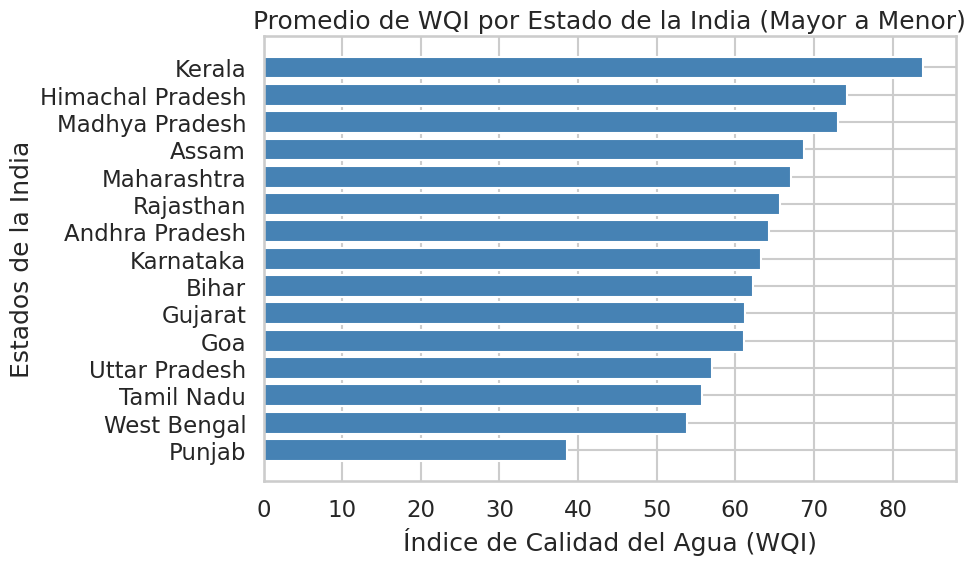

In [108]:
# Obtener promedio de WQI por estado y ordenarlos de mayor a menor
val_WQI_estado = spark.sql("SELECT STATE, AVG(WQI) as avg_WQI FROM df10_sql GROUP BY STATE ORDER BY avg_WQI DESC")
datos = val_WQI_estado.rdd.map(lambda fila: (fila.STATE, fila.avg_WQI)).collect()

# Separar los valores en listas
Estados = [fila[0] for fila in datos]
val_WQI = [fila[1] for fila in datos]

# Crear gráfico sin líneas entrecortadas
plt.figure(figsize=(10, 6))
plt.barh(Estados, val_WQI, color='steelblue')
plt.xlabel('Índice de Calidad del Agua (WQI)')
plt.ylabel('Estados de la India')
plt.title('Promedio de WQI por Estado de la India')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##Análisis:
La gráfica muestra el promedio del Índice de Calidad del Agua (WQI) por estado de la India, ordenado de mayor a menor. Se observa que Kerala, Himachal Pradesh y Madhya Pradesh presentan los promedios más altos de WQI, lo cual indica baja o muy baja calidad del agua en estas regiones. En contraste, estados como Punjab, West Bengal y Tamil Nadu muestran promedios de WQI más bajos, lo que sugiere mejor calidad del agua.

#**Creación de Modelo: Regresión Lineal**

* Se requiere predecir el valor WQI
* Se crea un vector ensamblador con las columnas **"Rangos de Calidad (qr)"**
* Se normalizan las columnas a través de Normalizer
* Se importa LinearRegression y se aplica los datos con el vector normalizado
* Se hace un "pipeline" para incluir el modelo
* Se separa los datos aleatoriamente (80%:entrenamiento, 20%:prueba)
* Se entrena el modelo con los datos de entrenamiento
* Se obtienen las predicciones con los datos de prueba y se muestran
* Se revisa el rendimiento del modelo con la métrica r2

In [49]:
sparkDF00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'qrPH',
 'qrDO',
 'qrCOND',
 'qrBOD',
 'qrNN',
 'qrFC',
 'wpH',
 'wDO',
 'wCOND',
 'wBOD',
 'wNN',
 'wFC',
 'WQI',
 'CALIDAD']

In [50]:
#Importar la biblioteca
from pyspark.ml.feature import VectorAssembler, Normalizer
#Se normalizan en un vector
vectorQR = VectorAssembler(inputCols=['qrPH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNN', 'qrFC'], outputCol='features')
normalizarQR = Normalizer(inputCol='features', outputCol='normFeatures')

In [51]:
#Se prepara el modelo de Regresión Lineal
from pyspark.ml.regression import LinearRegression

modelo_A_Lineal = LinearRegression(featuresCol='normFeatures', labelCol='WQI',maxIter=10, regParam=0.3, elasticNetParam=0.2)

In [52]:
from pyspark.ml import Pipeline
#Se crea el pipeline: presentar las etapas de procesamiento
pipe_A = Pipeline(stages=[vectorQR, normalizarQR, modelo_A_Lineal])

In [53]:
#Separación de datos aleatoriamente 20% para prueba y 80% para entrenamiento
train_data, test_data = sparkDF00.randomSplit([0.8, 0.2])

In [113]:
#Se crea el modelo LR para entrenamiento
LR_Modelo = pipe_A.fit(train_data)

###Entrenamiento:

In [114]:
from pyspark.sql.functions import format_number

#Se hacen las predicciones con los datos de entrenamiento
pred_Modelo_A = LR_Modelo.transform(train_data)

#Se muestran los valores redondeados a tres decimales
pred_Modelo_A.select(
    format_number('WQI', 3).alias('WQI'),
    format_number('prediction', 3).alias('prediction')
).show(14)

+------+----------+
|   WQI|prediction|
+------+----------+
|76.220|    75.413|
|20.200|    11.501|
|76.400|    74.964|
|74.520|    73.090|
|59.540|    60.068|
|68.900|    68.359|
|68.900|    68.359|
|48.120|    49.842|
|48.120|    49.842|
|48.120|    49.842|
|48.120|    49.842|
|68.900|    68.359|
|59.360|    59.785|
|59.360|    59.785|
+------+----------+
only showing top 14 rows



###Prueba:

In [115]:
# Se hacen las predicciones con los datos de prueba
pred_prueba_Modelo_A = LR_Modelo.transform(test_data)

# Se muestran los valores redondeados a tres decimales
pred_prueba_Modelo_A.select(
    format_number('WQI', 3).alias('WQI'),
    format_number('prediction', 3).alias('prediction')
).show(14)

+------+----------+
|   WQI|prediction|
+------+----------+
|74.340|    73.439|
|48.120|    49.842|
|68.900|    68.359|
|68.720|    68.482|
|59.540|    60.068|
|68.900|    68.359|
|59.360|    59.980|
|64.980|    65.074|
|59.360|    59.980|
|76.400|    74.964|
|62.340|    63.918|
|48.120|    49.842|
|31.080|    31.628|
|41.760|    59.772|
+------+----------+
only showing top 14 rows



###Evaluación del modelo:
- **MAE** (Error Absoluto Medio):   mide el promedio de los errores absolutos entre los valores reales y los predichos **[7]**.

- **R²** (Coeficiente de Determinación): indica qué proporción de la variabilidad de la variable dependiente es explicada por el modelo. Un R² cercano a 1 implica que el modelo tiene un buen ajuste y predice con alta precisión **[8]**.


In [123]:
# Inicializamos el evaluador con las predicciones ya hechas
evaluator = RegressionEvaluator(labelCol='WQI', predictionCol='prediction')

# Calculamos MAE y R²
mae = evaluator.setMetricName('mae').evaluate(pred_prueba_Modelo_A)
r2 = evaluator.setMetricName('r2').evaluate(pred_prueba_Modelo_A)

# Convertimos a porcentaje (suponiendo escala WQI de 0 a 100)
mae_pct = mae  # ya está en la misma escala
r2_pct = r2 * 100

# Mostramos los resultados
print(f"Error Absoluto Medio (MAE): {mae_pct:.2f}")
print(f"Coeficiente de Determinación (R²): {r2_pct:.2f}%")

Error Absoluto Medio (MAE): 1.63
Coeficiente de Determinación (R²): 94.77%


##Análisis de resultados:
Los resultados obtenidos muestran un Error Absoluto Medio (MAE) de 1.63, lo que indica que, en promedio, las predicciones del modelo se desvían solo 1.63 unidades del valor real del Índice de Calidad del Agua (WQI), una diferencia mínima considerando que el WQI suele estar en una escala de 0 a 100. Además, el Coeficiente de Determinación (R²) del 94.77% refleja que el modelo explica aproximadamente el 95% de la variabilidad de los datos, lo cual indica que el modelo es confiable para predicir el Índice de calidad del agua.

#**Creación de Modelo: Aprendizaje Profundo (Deep Learning)**

* Se requiere predecir el valor WQI
* Se crea un DF en pandas, se crea los vectores numpy de columnas **"Rangos de Calidad (qr)"** y **WQI**
* Se importa Scikit-Learn, para separar los datos (20% para prueba)
* Se importa Keras Sequential con layers Dense
* Se inicializa el modelo, y se añaden las capas
* Se compila el modelo con el optimizador Adam y la función de pérdida error cuadrático medio.
* Se realiza el entrenamiento

In [60]:
pandasDF.columns

Index(['STATION CODE', 'LOCATIONS', 'STATE', 'TEMP', 'DO', 'pH',
       'CONDUCTIVITY', 'BOD', 'NITRATE_N_NITRITE_N', 'FECAL_COLIFORM', 'qrPH',
       'qrDO', 'qrCOND', 'qrBOD', 'qrNN', 'qrFC', 'wpH', 'wDO', 'wCOND',
       'wBOD', 'wNN', 'wFC', 'WQI', 'CALIDAD'],
      dtype='object')

In [61]:
#Se obtienen en vector numpy datos de los rangos de calidad de los parámetros (qrParametros)
datos =pandasDF.iloc[:,10:16].values
#Se obtienen en vector numpy datos de valor a predecir "WQI"
prede =pandasDF.iloc[:,22:23].values

In [62]:
#Separación de datos con scikit-learn: train_test_split
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(datos,prede,test_size=0.2,random_state=1)

In [63]:
print(f"Cantidad de datos totales = {pandasDF.shape}")
print(f"Cantidad de datos de entrenamiento = {x_train.shape}")
print(f"Cantidad de datos de prueba = {x_test.shape}")
print(f"Cantidad de predicción de entrenamiento = {y_train.shape}")
print(f"Cantidad de predicción de prueba = {y_test.shape}")

Cantidad de datos totales = (447, 24)
Cantidad de datos de entrenamiento = (357, 6)
Cantidad de datos de prueba = (90, 6)
Cantidad de predicción de entrenamiento = (357, 1)
Cantidad de predicción de prueba = (90, 1)


In [64]:
#Se importa instancia TensorFlow
import keras
from keras.models import Sequential
from keras.layers import Dense

In [65]:
#Se ajustan las variables
epocas=200
lotes = 81
#Se inicializa el modelo con las capas
model_DL = Sequential()
model_DL.add(Dense(350, input_dim=6, activation='relu'))
model_DL.add(Dense(350, activation='relu'))
model_DL.add(Dense(350, activation='relu'))
model_DL.add(Dense(1, activation='linear'))

In [66]:
## Se compila el modelo con el optimizador Adam y la función de perdida de error cuadrático medio
keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,amsgrad=False)
model_DL.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse'])

In [67]:
#Se presenta el resumen del modeloDL
model_DL.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 350)                 │           2,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

###Entrenamiento:

In [68]:
##Se entrena el modelo
rendi_Mod_DL = model_DL.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 826.4014 - mse: 826.4014
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 46.6218 - mse: 46.6218
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.7202 - mse: 5.7202
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0218 - mse: 3.0218
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7560 - mse: 0.7560
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3150 - mse: 0.3150
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1740 - mse: 0.1740
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1063 - mse: 0.1063
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0599 - mse: 0.0599
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0525 - mse: 0.0525
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0341 - mse: 0.0341
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0312 - mse: 0.0312
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 

In [69]:
#Se calcula la predicción
pred_DL_Train=model_DL.predict(x_train)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


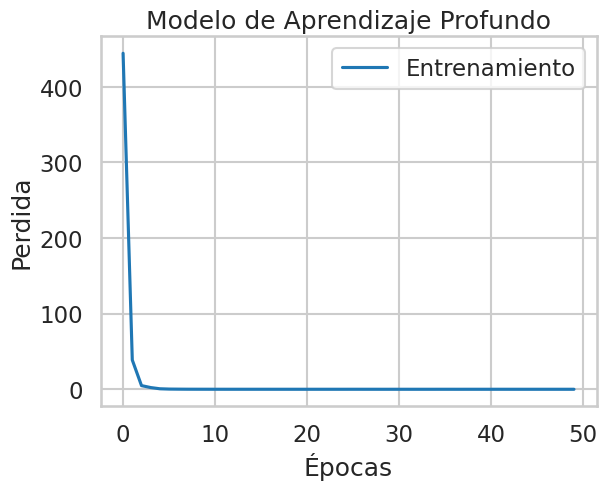

In [70]:
#Se pinta la perdida: rendimiento del modelo    #Tarea hacer analisis con datos de prueba
plt.plot(rendi_Mod_DL.history['loss'])
plt.title('Modelo de Aprendizaje Profundo')
plt.ylabel('Perdida')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento'], loc='upper right')
plt.show()


La gráfica muestra la evolución de la función de pérdida del modelo de aprendizaje profundo a lo largo de 50 épocas. Se observa una disminución rápida y pronunciada de la pérdida en las primeras épocas, lo que indica un aprendizaje eficiente del modelo. A partir de la época 10, la pérdida se estabiliza cerca de cero, lo que sugiere una convergencia adecuada y un buen ajuste del modelo a los datos de entrenamiento, sin signos aparentes de sobreajuste.

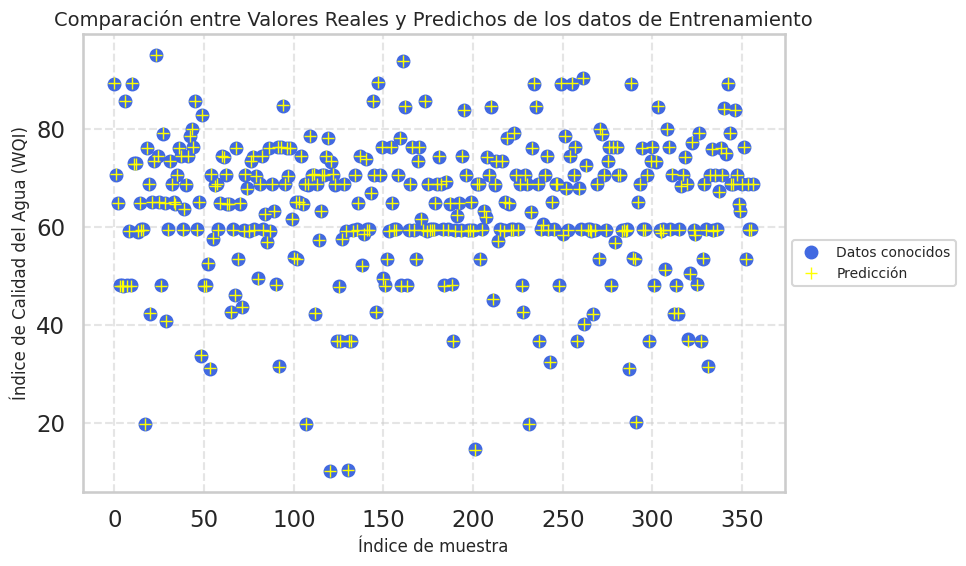

In [142]:
#Se pinta las predicciones sobre datos conocidos (entrenamiento)
plt.figure(figsize=(10, 6))
plt.plot(y_train, 'o', color='royalblue', label='Datos conocidos')
plt.plot(pred_DL_Train, '+', color='yellow', label='Predicción')

plt.title('Comparación entre Valores Reales y Predichos de los datos de Entrenamiento', fontsize=14)
plt.xlabel('Índice de muestra', fontsize=12)
plt.ylabel('Índice de Calidad del Agua (WQI)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.show()


La gráfica presenta la comparación entre los valores reales y las predicciones del modelo de aprendizaje profundo usando los datos de entrenamiento. La alta superposición entre los puntos reales (azules) y las predicciones del modelo (cruces amarillas) sugiere que el modelo ha logrado un ajuste muy preciso sobre los datos con los que fue entrenado.


###Prueba:

In [148]:
#Se evalua el modelo con los datos de prueba
pred_DL_Test = model_DL.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


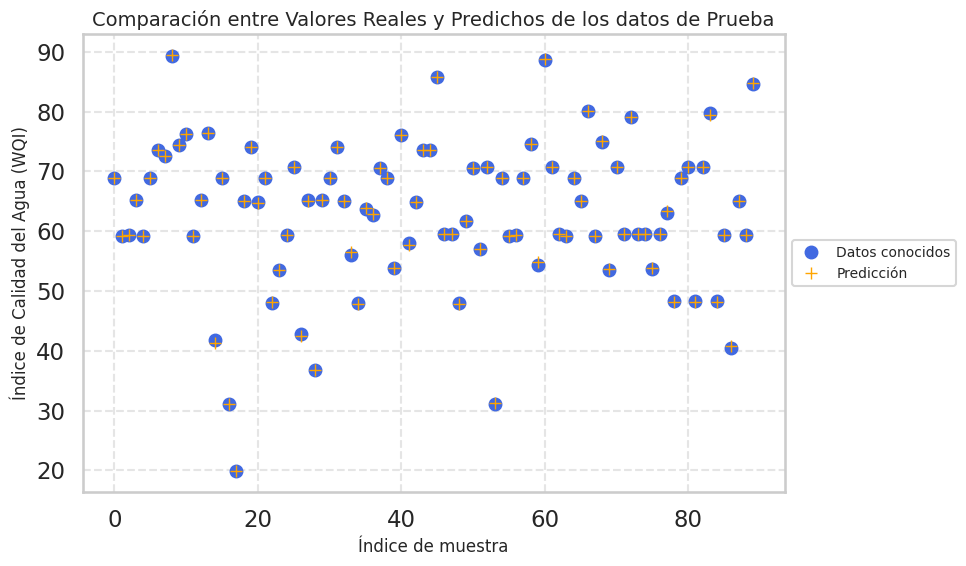

In [155]:
#Se pinta las predicciones sobre datos conocidos (prueba)
plt.figure(figsize=(10, 6))
plt.plot(y_test, 'o', color='royalblue', label='Datos conocidos')
plt.plot(pred_DL_Test, '+', color='orange', label='Predicción')

plt.title('Comparación entre Valores Reales y Predichos de los datos de Prueba', fontsize=14)
plt.xlabel('Índice de muestra', fontsize=12)
plt.ylabel('Índice de Calidad del Agua (WQI)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.show()


La gráfica muestra la comparación entre los valores reales del Índice de Calidad del Agua (WQI) y las predicciones generadas por el modelo de aprendizaje profundo sobre los datos de prueba. Se observa una alta coincidencia entre los puntos reales (azules) y las predicciones (cruces naranjas), lo que indica que el modelo logra generalizar adecuadamente y mantiene una buena capacidad predictiva fuera del conjunto de entrenamiento.

#**Predicción de la Calidad del Agua**

* Hasta ahora se predice el Indice de Calida de Agua.
* Se requiere clasificar el agua según el WQI que se predice y así predecir su calidad.
* Se crea un modelo de Regresión Logística para predecir valores por categorias.
* La columna 'CALIDAD' contiene formato 'string', se convierte a 'StringIndexer'
* Se crea un vector assembler para los datos del índice
* Se normaliza los valores en el vector

In [156]:
#Se convierte a spark dataframe
df_spark = spark.createDataFrame(pandasDF)

In [157]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression

In [162]:
df_spark.dtypes

[('STATION CODE', 'bigint'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'double'),
 ('DO', 'double'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'double'),
 ('BOD', 'double'),
 ('NITRATE_N_NITRITE_N', 'double'),
 ('FECAL_COLIFORM', 'double'),
 ('qrPH', 'bigint'),
 ('qrDO', 'bigint'),
 ('qrCOND', 'bigint'),
 ('qrBOD', 'bigint'),
 ('qrNN', 'bigint'),
 ('qrFC', 'bigint'),
 ('wpH', 'double'),
 ('wDO', 'double'),
 ('wCOND', 'double'),
 ('wBOD', 'double'),
 ('wNN', 'double'),
 ('wFC', 'double'),
 ('WQI', 'double'),
 ('CALIDAD', 'string')]

In [225]:
# Convertir la columna 'CALIDAD' en índices numéricos
indexer = StringIndexer(inputCol="CALIDAD", outputCol="Calidad_Index")

In [226]:
#Se crea un vector essembler y se normaliza
vectorQR = VectorAssembler(inputCols=['qrPH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNN', 'qrFC'], outputCol='features')
normalizerQR = Normalizer(inputCol='features', outputCol='normFeatures')

In [227]:
#Se crea el modelo de Regresión Logística
modelo_RL = LogisticRegression(featuresCol='normFeatures', labelCol='Calidad_Index', maxIter=10)

#Se crea el pipeline para aplicar las configuraciones
pipe_RL = Pipeline(stages=[indexer, vectorQR, normalizerQR, modelo_RL])

In [228]:
# Se dividen los datos en 80% entrenamiento y 20% prueba
datos_entrenamiento, datos_prueba = df_spark.randomSplit([0.8, 0.2])

# Se implementa el modelo de Regresión Logística
LR_model = pipe_RL.fit(datos_entrenamiento)

###Entrenamiento:

In [298]:
#### Predicción sobre los datos de entrenamiento
pred_LR_Train = LR_model.transform(datos_entrenamiento)

### Se observan
pred_LR_Train.select('Calidad_Index', 'prediction').show(14)

+-------------+----------+
|Calidad_Index|prediction|
+-------------+----------+
|          1.0|       1.0|
|          3.0|       2.0|
|          1.0|       1.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          2.0|       2.0|
|          2.0|       2.0|
|          2.0|       2.0|
|          2.0|       2.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
+-------------+----------+
only showing top 14 rows



###Prueba:

In [299]:
#### Predicción sobre prueba
pred_LR_Test = LR_model.transform(datos_prueba)
### Se observan
pred_LR_Test.select('Calidad_Index', 'prediction').show(14)

+-------------+----------+
|Calidad_Index|prediction|
+-------------+----------+
|          0.0|       0.0|
|          0.0|       0.0|
|          2.0|       2.0|
|          0.0|       0.0|
|          2.0|       2.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          1.0|       1.0|
|          1.0|       1.0|
|          0.0|       0.0|
|          2.0|       2.0|
|          1.0|       1.0|
|          0.0|       0.0|
+-------------+----------+
only showing top 14 rows



###Evaluación del modelo:
- Accuracy (precisión global) indica el porcentaje de predicciones correctas respecto al total. Es útil cuando las clases están balanceadas.**[9]**
- F1-score combina precisión y recall, y es especialmente valiosa cuando hay desequilibrio de clases, ya que considera tanto los falsos positivos como los falsos negativos. **[10]**

No se usan métricas como el MAE o R² porque esas son propias de regresión continua, y en este caso estamos clasificando la calidad del agua por categorías (clasificación múltiple).

In [249]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluador para precisión (accuracy)
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="Calidad_Index", predictionCol="prediction", metricName="accuracy")

# Evaluador para F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="Calidad_Index", predictionCol="prediction", metricName="f1")

# Evaluación
accuracy = evaluator_acc.evaluate(pred_LR_Test)
f1 = evaluator_f1.evaluate(pred_LR_Test)

# Mostrar resultados en porcentaje
print(f"Precisión (Accuracy): {accuracy * 100:.2f}%")
print(f"F1-score: {f1 * 100:.2f}%")

Precisión (Accuracy): 98.95%
F1-score: 99.10%


###Análisis:
Los resultados obtenidos reflejan un desempeño sobresaliente del modelo de regresión logística. La precisión (accuracy) del 98.95% indica que casi todas las predicciones del modelo coinciden con los valores reales, lo que sugiere que el modelo es altamente confiable para clasificar la calidad del agua. Además, el F1-score de 99.10% confirma que el modelo mantiene un excelente equilibrio entre precisión y sensibilidad, siendo capaz de identificar correctamente cada categoría sin favorecer una clase sobre otra.

* Como la columna "CALIDAD" esta en formato string (categorias), se convierten los valores que predicen a formato string y así compararlos en categorias.

In [294]:
##Se obtienen las categorias
categorias = pred_LR_Test.select('CALIDAD', 'Calidad_Index').distinct().collect()
print(categorias)

[Row(CALIDAD='Baja', Calidad_Index=0.0), Row(CALIDAD='Buena', Calidad_Index=2.0), Row(CALIDAD='Muy Baja', Calidad_Index=1.0), Row(CALIDAD='Excelente', Calidad_Index=3.0)]


In [295]:
#Se crea una función que crea una nueva columna con las predicciones en string
from pyspark.ml.feature import IndexToString, StringIndexer

modelo_indexador = indexer.fit(df_spark)

convertidor = IndexToString(
    inputCol="prediction",                      # Columna de predicción en índices numéricos
    outputCol="prediction_Category",            # Columna de salida con etiquetas en string
    labels=modelo_indexador.labels              # Lista de etiquetas en orden original
)

In [297]:
# Aplicamos la conversión del índice a string sobre los resultados de entrenamiento
predicciones_con_etiquetas = convertidor.transform(pred_LR_Train)

# Mostramos las primeras 20 predicciones con sus respectivas etiquetas
predicciones_con_etiquetas.select("CALIDAD", "prediction_Category").show(20, truncate=False)

+---------+-------------------+
|CALIDAD  |prediction_Category|
+---------+-------------------+
|Muy Baja |Muy Baja           |
|Excelente|Buena              |
|Muy Baja |Muy Baja           |
|Baja     |Baja               |
|Baja     |Baja               |
|Baja     |Baja               |
|Buena    |Buena              |
|Buena    |Buena              |
|Buena    |Buena              |
|Buena    |Buena              |
|Baja     |Baja               |
|Baja     |Baja               |
|Baja     |Baja               |
|Baja     |Baja               |
|Baja     |Baja               |
|Buena    |Buena              |
|Baja     |Baja               |
|Baja     |Baja               |
|Buena    |Buena              |
|Baja     |Baja               |
+---------+-------------------+
only showing top 20 rows



In [296]:
# Aplicamos la conversión del índice a string sobre los resultados de prueba
predicciones_con_etiquetas = convertidor.transform(pred_LR_Test)

# Mostramos las primeras 20 predicciones con sus respectivas etiquetas
predicciones_con_etiquetas.select("CALIDAD", "prediction_Category").show(20, truncate=False)

+--------+-------------------+
|CALIDAD |prediction_Category|
+--------+-------------------+
|Baja    |Baja               |
|Baja    |Baja               |
|Buena   |Buena              |
|Baja    |Baja               |
|Buena   |Buena              |
|Baja    |Baja               |
|Baja    |Baja               |
|Baja    |Baja               |
|Muy Baja|Muy Baja           |
|Muy Baja|Muy Baja           |
|Baja    |Baja               |
|Buena   |Buena              |
|Muy Baja|Muy Baja           |
|Baja    |Baja               |
|Baja    |Baja               |
|Baja    |Baja               |
|Baja    |Baja               |
|Baja    |Baja               |
|Baja    |Baja               |
|Baja    |Baja               |
+--------+-------------------+
only showing top 20 rows



#**Conclusiones**
1. Gran parte de la India enfrenta serios problemas de calidad del agua, con muchas regiones clasificadas con calidad del agua baja o muy baja, lo cual indica condiciones poco favorables para el consumo humano.

2. Que la **regresión linea** funcione bien sobre los datos significa que existe una relación lineal fuerte y consistente entre las caracteristicas del agua y el Índice de Calidad del Agua (WQI), lo que permite modelar su comportamiento de forma precisa. Esto se refleja en un R² de 94.77%, que indica que el modelo explica casi toda la variabilidad del WQI, y un MAE de solo 1.63, mostrando que las predicciones son muy cercanas a los valores reales.

3. El **modelo de aprendizaje profundo** aplicado para predecir el Índice de Calidad del Agua (WQI) mostró un desempeño notable, evidenciado por la alta coincidencia visual entre los valores reales y las predicciones en los datos de prueba. A través del uso de redes neuronales densas y la optimización con Adam, el modelo fue capaz de capturar patrones complejos en los datos y generalizar bien, lo que sugiere que es una alternativa robusta para predecir el WQI incluso cuando las relaciones entre variables no son estrictamente lineales.

4. Los resultados obtenidos reflejan un buen desempeño del modelo de **regresión logística**. La precisión (accuracy) del 98.95% indica que casi todas las predicciones del modelo coinciden con los valores reales, lo que sugiere una alta confiabilidad para clasificar la calidad del agua. Además, el F1-score de 99.10% confirma que el modelo mantiene un excelente equilibrio entre precisión y sensibilidad, logrando identificar correctamente cada categoría sin sesgo hacia ninguna clase en particular. Este modelo resulta especialmente adecuado en este caso, ya que está diseñado para predecir clases o categorías, en lugar de valores continuos.

5. **PySpark** es una herramienta altamente eficiente para el manejo de grandes volúmenes de datos, gracias a su capacidad de procesamiento distribuido. Su integración con Apache Spark permite realizar análisis complejos, transformaciones y modelado de datos de manera rápida y escalable.

# **Referencias**

* **[1]** Spellman FR. Handbook of Water and Wastewater Treatment Plant Operations. 3rd ed. Boca Raton: CRC Press; 2013.
* **[2]** Summer Kevin. [Water Quality](https://www.intechopen.com/chapters/69568). IntechOpen; DOI 978-1-78985-578-4.2020.
* **[3]** Hammer MJ. Water and Wastewater Technology. 7th ed. Upper Saddle River: Pearson education; 2011.
* **[4]** Tchobanoglous G, Burton FL, Stensel HD. Metcalf & Eddy Wastewater Engineering: Treatment and Reuse. 4th ed. New Delhi: Tata McGraw-Hill Limited; 2003.
* **[5]** Alley ER. Water Quality Control Handbook. Vol. 2. New York: McGraw-Hill; 2007.

* **[6]** Nathanson JA. Basic Environmental Technology: Water Supply. New Delhi: Printice-Hall of India; 2004
* **[7]** Chai, T. and Draxler, R.R. (2014) Root Mean Square Error (RMSE) or Mean Absolute Error (MAE)?—Arguments against Avoiding RMSE in the Literature. Geoscientific Model Development

* **[8]** Scikit-learn Developers. (2024). sklearn.metrics.r2_score.

* **[9]** Scikit-learn documentation. Accuracy score
* **[10]** Scikit-learn documentation. F1 score.



